In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
# Uncomment to download "stopwords"
# nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [7]:
id_list= open('./pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt','r').read()


In [14]:
readme= open('./Sexual_predator_dataset/pan12-sexual-predator-identification-training-corpus-2012-05-01/readme.txt','r').read()

In [15]:
print(readme)

Overview

This archive contains the training corpus for the "Sexual Predator Identification" task of the PAN 2012 Lab, held in conjunction with the CLEF 2012 conference.

Find out about all the details at http://pan.webis.de.



Training Corpus Description

Update 01 May 2012:

pan12-sexual-predator-identification-training-corpus-2012-05-01.xml A new xml file containing conversations without bad username substitution.
pan12-sexual-predator-identification-diff.txt A text file containing conversation id and line number of modified text 
pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt The list of predators without the ones not present in the traininig set



The corpus comprises:

pan12-sexual-predator-identification-training-corpus.xml An xml file containing around 60000 documents (each document is a conversation)
pan12-sexual-predator-identification-training-corpus-predators.txt A file containing a list of predators id

The xml file is organized as follow:


In [3]:
tree = ET.parse('./pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-2012-05-01.xml')
root = tree.getroot()

In [12]:
# dir(child)
text=[]
label=[]
for messages in root.iter('message'):
  for ele in messages.getchildren():
    if ele.tag=='author':
      label.append(int(ele.text in id_list))
    elif ele.tag=='text':
      text.append(ele.text)
texts=[]
labels=[]
for i in range (len(text)):
  if text[i]!=None:
    texts.append(text[i])
    labels.append(label[i])
    # break
    # del texts[i]
    # del labels[i]

In [124]:
len(texts)

900632

In [9]:



def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [12]:
range(len(texts))


range(0, 900632)

In [18]:
df =pd.DataFrame({'text':texts,"labels":labels})
df['text']=df['text'].apply(text_preprocessing)

In [19]:
# modelling

X_train_preprocessed,X_val_preprocessed,y_train,y_val = train_test_split(df['text'],df['labels'], test_size=0.2,stratify=labels)

In [20]:
# Preprocess text
# X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
# X_val_preprocessed = np.array([text_preprocessing(text) for text in X_test])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [21]:
import pickle
with open('./X_train_preprocessed.pkl','wb') as f:
    pickle.dump(X_train_preprocessed,f)
with open('./X_val_preprocessed.pkl','wb') as f:
    pickle.dump(X_val_preprocessed,f)

# X_train_preprocessed=pickle.load(open('./X_train_preprocessed.pkl','rb'))
# X_val_preprocessed =pickle.load(open('./X_val_preprocessed.pkl','rb'))

In [22]:
def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  0.4


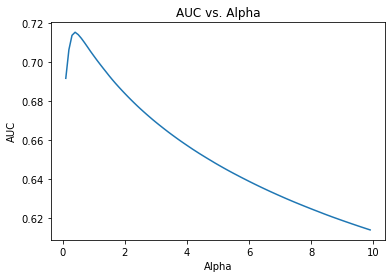

In [26]:
# Trying Multinomial algorithms
res_mnb = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(0.1, 10, 0.1)],
                index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res_mnb.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res_mnb)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

Best C:  10.0


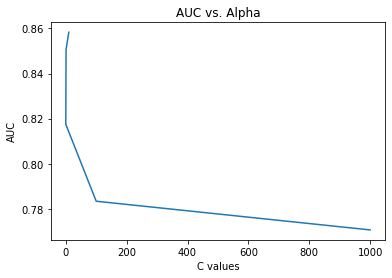

In [29]:
#Try logistic regression
res_log = pd.Series([get_auc_CV(LogisticRegression(C=i))
                 for i in [0.001, 0.01, 0.1, 1, 10]],
                index=[1000, 100, 0.1, 1, 10])

best_C = np.round(res_log.idxmax(), 2)
print('Best C: ', best_C)

plt.plot(res_log)
plt.title('AUC vs. Alpha')
plt.xlabel('C values')
plt.ylabel('AUC')
plt.show()

In [39]:


def evaluate_roc(preds, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
#     preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


AUC: 0.7856
Accuracy: 95.48%


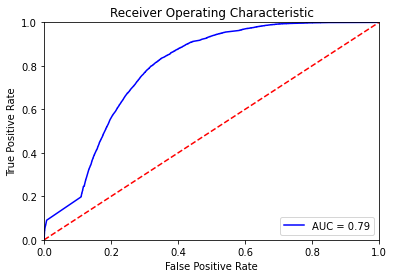

In [40]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=0.4)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)
preds = probs[:, 1]
# Evaluate the classifier
evaluate_roc(preds, y_val)

AUC: 0.8631
Accuracy: 95.39%


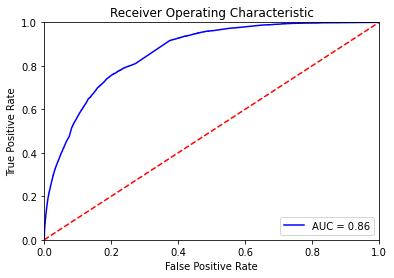

In [45]:
log_reg=LogisticRegression(C=10)
log_reg.fit(X_train_tfidf, y_train)
probs=log_reg.predict_proba(X_val_tfidf)
preds = probs[:, 1]
evaluate_roc(preds, y_val)